In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Loading the necessary only (because of large size of nse stock data):

In [2]:
dtypes = {
    "Open": "float32",
    "Close": "float32",
    "Symbol": "category"
}

stock_chunks = pd.read_csv(
    "../data/adjusted_stock_data_stripped_appended_daily.csv",
    chunksize=1_000_000, # reading in chunks of a million to not overload memory
    usecols=["Date", "Open", "Close", "Symbol"],
    dtype=dtypes,
    parse_dates=["Date"]
)

### Intraday return (Close - Morning) / Morning for NSE stocks:

In [3]:
processed_data = []

for chunk in stock_chunks:
    # computing intraday return
    chunk["intraday_return"] = (chunk["Close"] - chunk["Open"]) / chunk["Open"]

    # keeping only what is needed
    processed_data.append(
        chunk[["Date", "Symbol", "intraday_return"]]
    )

In [4]:
stock_intraday_returns = pd.concat(processed_data, ignore_index=True)

In [5]:
stock_intraday_returns.head()

,Date,Symbol,intraday_return
0,2024-07-30,RELIANCE,-0.002554
1,2024-07-29,RELIANCE,0.005390
2,2024-07-26,RELIANCE,0.011140
3,2024-07-25,RELIANCE,0.007698
4,2024-07-24,RELIANCE,0.007205


In [6]:
stock_intraday_returns.describe()

,Date,intraday_return
count,7482187,7.482187e+06
mean,2016-09-03 19:11:20.258379520,-2.335068e-03
min,2002-08-12 00:00:00,-8.427813e-01
25%,2011-09-27 00:00:00,-1.789716e-02
50%,2017-09-18 00:00:00,-1.569932e-03
75%,2022-02-28 00:00:00,9.933686e-03
max,2025-11-28 00:00:00,1.961728e+01
std,NaN,3.602888e-02


In [7]:
stock_intraday_returns.info() # now here dtypes initializaion reduced the memory usage significantly from 171 mb to 142 mb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7482187 entries, 0 to 7482186
Data columns (total 3 columns):
 #   Column           Dtype         
---  ------           -----         
 0   Date             datetime64[ns]
 1   Symbol           object        
 2   intraday_return  float32       
dtypes: datetime64[ns](1), float32(1), object(1)
memory usage: 142.7+ MB


In [8]:
gold = pd.read_csv("../data/gold_spot_prices.csv") # loading normally as it's a small file
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19635 entries, 0 to 19634
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Symbol             19635 non-null  object
 1   QuotationValue     19635 non-null  object
 2   UpdatedDate        19635 non-null  object
 3   Session1SpotPrice  19635 non-null  object
 4   Session2SpotPrice  19635 non-null  object
 5   PolledInfo         19635 non-null  object
dtypes: object(6)
memory usage: 920.5+ KB


In [9]:
gold = gold[gold["Symbol"] == "GOLD"].copy() # keeping only gold data as asked in problem setup

In [10]:
# parsing date
gold["UpdatedDate"] = pd.to_datetime(gold["UpdatedDate"], dayfirst=True)

# cleaning price columns (removing the commas, and - signs, converting to float)
gold["Session2SpotPrice"] = (
    gold["Session2SpotPrice"]
    .astype(str)
    .str.replace(",", "")
    .replace("-", None)
    .astype(float) # gold dataset is not so large, so i'll go with float 64 for more precision
)

# sorting in chronological order:
gold = gold.sort_values("UpdatedDate").reset_index(drop=True)

In [11]:
gold = gold.rename(columns={
    "UpdatedDate": "Date",
    "Session2SpotPrice": "Gold_Close"
})

gold = gold[["Date", "Gold_Close"]]

### Defining gold return as (Close - Close_previous) / (Close_previous):

In [12]:
gold["gold_return"] = gold["Gold_Close"].pct_change() # computing daily returns
gold = gold.dropna().reset_index(drop=True) # dropping first row with NaN return because we had no close price before that

In [13]:
gold.head()

,Date,Gold_Close,gold_return
0,2018-10-15,31948.0,0.012743
1,2018-10-16,31800.0,-0.004633
2,2018-10-17,31741.0,-0.001855
3,2018-10-19,31737.0,-0.000126
4,2018-10-22,31609.0,-0.004033


## Ask 1:
### Since we need a combination of gold and stock data report the date range between which you will be able to run the experiments

In [14]:
stock_start = stock_intraday_returns["Date"].min()
stock_end   = stock_intraday_returns["Date"].max()

gold_start = gold["Date"].min()
gold_end   = gold["Date"].max()

analysis_start = max(stock_start, gold_start)
analysis_end   = min(stock_end, gold_end)

analysis_start, analysis_end

(Timestamp('2018-10-15 00:00:00'), Timestamp('2025-11-28 00:00:00'))

In [15]:
# creating Year columns for easier grouping later
gold["Year"] = gold["Date"].dt.year
stock_intraday_returns["Year"] = stock_intraday_returns["Date"].dt.year

In [16]:
# Restricting both datasets to the common analysis window so all subsequent computations are restricted to the overlapping date range
gold = gold[(gold["Date"] >= analysis_start) & (gold["Date"] <= analysis_end)].copy()

stock_intraday_returns = stock_intraday_returns[
    (stock_intraday_returns["Date"] >= analysis_start) &
    (stock_intraday_returns["Date"] <= analysis_end)
].copy()

## Ask 2:
### For every year in the dataset Y, for all data upto the year end, find the Top Gold and Bottom Gold (95% return and 5% return respectively)

In [17]:
gold_thresholds = []

for year in sorted(gold["Year"].unique()):
    data_upto_year = gold[gold["Year"] <= year]["gold_return"]
    # cumulative threshold — each year’s thresholds are based on all data available up to that point, not just that year.

    top_95 = data_upto_year.quantile(0.95)
    bottom_5 = data_upto_year.quantile(0.05)

    gold_thresholds.append({
        "Year": year,
        "Top_Gold_95": top_95,
        "Bottom_Gold_5": bottom_5
    })

gold_thresholds = pd.DataFrame(gold_thresholds)

In [ ]:
gold_thresholds.head()
# this is how one can read this, for the 4th index: by the end of 2022, gold had become less volatile compared to 2019, so extreme days were defined at +4.0% and −2.9% instead

,Year,Top_Gold_95,Bottom_Gold_5
0,2018,0.011530,-0.007652
1,2019,0.072376,-0.041124
2,2020,0.049210,-0.026102
3,2021,0.047027,-0.034211
4,2022,0.040077,-0.028756


## Ask 3: 
### For every year Y, use the bottom gold and top gold value from the previous year Y-1 and use it to identify days in Y when the previous business day were Top Gold and Bottom Gold respectively

In [19]:
gold = gold.merge(
    gold_thresholds,
    on="Year",
    how="left"
)
gold.head()

,Date,Gold_Close,gold_return,Year,Top_Gold_95,Bottom_Gold_5
0,2018-10-15,31948.0,0.012743,2018,0.01153,-0.007652
1,2018-10-16,31800.0,-0.004633,2018,0.01153,-0.007652
2,2018-10-17,31741.0,-0.001855,2018,0.01153,-0.007652
3,2018-10-19,31737.0,-0.000126,2018,0.01153,-0.007652
4,2018-10-22,31609.0,-0.004033,2018,0.01153,-0.007652


In [20]:
gold["Prev_Year"] = gold["Year"] - 1 # To use previous year's thresholds for current year

gold = gold.merge(
    gold_thresholds.rename(columns={
        "Year": "Prev_Year",
        "Top_Gold_95": "Prev_Top_95",
        "Bottom_Gold_5": "Prev_Bottom_5"
    }),
    on="Prev_Year",
    how="left"
)

#### This step 👇🏻 is done for the sake of definition, even if we don't run it, it gonna work the same because of further cells:

In [21]:
# excluding periods where previous-year gold thresholds are unavailable.
# as per definition 4, extreme gold movements are defined using gold returns
# "upto that point", i.e, using only historical information.
# therefore, for the first year in the dataset, previous-year thresholds can not be computed and those periods are excluded to avoid look-ahead bias and undefined extreme classifications.
gold = gold.dropna(subset=["Prev_Top_95", "Prev_Bottom_5"]).reset_index(drop=True)
# this is done for the sake of this analysis, in real trading scenarios, one might consider alternative approaches to handle such initial periods.
# i'm further dropping the nulls from Extreme_type already so even without this step it will work as same, but it's done for conceptual correctness and clarity here it's explicitly saying: 
# From this point onward, all rows are evaluable under definition 4.

In [22]:
gold.head()

,Date,Gold_Close,gold_return,Year,Top_Gold_95,Bottom_Gold_5,Prev_Year,Prev_Top_95,Prev_Bottom_5
0,2019-01-01,31539.0,-0.000792,2019,0.072376,-0.041124,2018,0.01153,-0.007652
1,2019-01-01,31539.0,0.000000,2019,0.072376,-0.041124,2018,0.01153,-0.007652
2,2019-01-02,33155.0,0.051238,2019,0.072376,-0.041124,2018,0.01153,-0.007652
3,2019-01-03,32843.0,-0.009410,2019,0.072376,-0.041124,2018,0.01153,-0.007652
4,2019-01-04,31637.0,-0.036720,2019,0.072376,-0.041124,2018,0.01153,-0.007652


In [23]:
# gold["Extreme_Type"] = np.where(
#     gold["gold_return"] >= gold["Prev_Top_95"], "Top_Gold",
#     np.where(gold["gold_return"] <= gold["Prev_Bottom_5"], "Bottom_Gold", None)
# ) # Nested np.where can get messy if we add more categories later.

gold["Extreme_type"] = None
gold.loc[gold["gold_return"] >= gold["Prev_Top_95"], "Extreme_type"] = "Top_Gold"
gold.loc[gold["gold_return"] <= gold["Prev_Bottom_5"], "Extreme_type"] = "Bottom_Gold"
# Easy to extend (we can add more conditions like "Moderate_Gold" or "Neutral" if required with this approach).

In [26]:
# Retain only extreme gold days
gold_extreme = gold.dropna(subset=["Extreme_type"]).reset_index(drop=True)

In [27]:
gold_extreme.head()
# read it like this: on 2 Jan 2019, gold rose by +5.12%, based on 2018’s historical gold behavior, any return above +1.15% is considered extreme, therefore, 2 Jan 2019 is classified as a Top Gold day.

,Date,Gold_Close,gold_return,Year,Top_Gold_95,Bottom_Gold_5,Prev_Year,Prev_Top_95,Prev_Bottom_5,Extreme_type
0,2019-01-02,33155.0,0.051238,2019,0.072376,-0.041124,2018,0.01153,-0.007652,Top_Gold
1,2019-01-03,32843.0,-0.009410,2019,0.072376,-0.041124,2018,0.01153,-0.007652,Bottom_Gold
2,2019-01-04,31637.0,-0.036720,2019,0.072376,-0.041124,2018,0.01153,-0.007652,Bottom_Gold
3,2019-01-07,33567.0,0.061005,2019,0.072376,-0.041124,2018,0.01153,-0.007652,Top_Gold
4,2019-01-08,34614.0,0.031191,2019,0.072376,-0.041124,2018,0.01153,-0.007652,Top_Gold


## Ask 4:
### For the exact day following Top Gold and Bottom Gold, get intraday stock return for each company from NSE for that day

In [28]:
gold_extreme["reaction_date"] = gold_extreme["Date"] + pd.offsets.BDay(1) # it deterministically moves to the next business day, independent of missing rows in gold, this usually aligns better with equities or any instrument that trades on business days
# i didn't used gold_extreme["reaction_date"] = gold_extreme["Date"].shift(-1) because that would just shift the date down by one row, which may not be the next business day if there are missing dates(by chance in worst case) in the gold dataset.
reaction_days = gold_extreme[["reaction_date", "Extreme_type", "Year"]]
reaction_days = reaction_days.rename(columns={"reaction_date": "Date"})

In [29]:
reaction_days.head()

,Date,Extreme_type,Year
0,2019-01-03,Top_Gold,2019
1,2019-01-04,Bottom_Gold,2019
2,2019-01-07,Bottom_Gold,2019
3,2019-01-08,Top_Gold,2019
4,2019-01-09,Top_Gold,2019


In [30]:
# getting intraday stock returns for only those reaction days
stock_reactions = stock_intraday_returns.merge(
    reaction_days,
    on=["Date", "Year"],
    how="inner"
)

In [31]:
stock_reactions.head()
# this is how one can read it: on 24 July 2024, the stock RELIANCE gained ~0.72% during the day, and this day is included because the previous business day had an extremely negative gold movement.
# on 13 December 2023, RELIANCE rose by ~0.49% intraday, and this happened after a day when gold had an extremely positive return.

,Date,Symbol,intraday_return,Year,Extreme_type
0,2024-07-24,RELIANCE,0.007205,2024,Bottom_Gold
1,2023-12-13,RELIANCE,0.004934,2023,Top_Gold
2,2023-12-05,RELIANCE,-0.000513,2023,Top_Gold
3,2023-12-04,RELIANCE,-0.012163,2023,Bottom_Gold
4,2023-11-13,RELIANCE,-0.003573,2023,Top_Gold


## Ask 5: 
### For the entire year, get the average stock return for each company on Top Gold following days of the year (and similarly separately for Bottom Gold following days of the year)

In [32]:
avg_returns = (
    stock_reactions
    .groupby(["Year", "Symbol", "Extreme_type"])
    .agg(
        avg_intraday_return=("intraday_return", "mean"), # average intraday return on reaction days
        reaction_days=("intraday_return", "count") # to ensure there are enough reaction days for the average to be meaningful, it wasn't asked but done for robustness and sanity check
    )
    .reset_index()
)


In [33]:
avg_returns.head(6)
# this is how one can read it: in 2019, on 84 trading days where the previous day’s gold movement was extremely low, the stock 20MICRONS had an average intraday return of −0.904%

,Year,Symbol,Extreme_type,avg_intraday_return,reaction_days
0,2019,20MICRONS,Bottom_Gold,-0.009040,84
1,2019,20MICRONS,Top_Gold,-0.015052,98
2,2019,21STCENMGM,Bottom_Gold,-0.001692,42
3,2019,21STCENMGM,Top_Gold,-0.003052,49
4,2019,360ONE,Bottom_Gold,-0.019274,11
5,2019,360ONE,Top_Gold,-0.024624,11


## Ask 6:
### Now, for averages for each company for Top Gold, find a df.describe() to identify the Top 5% average return companies. Get the return value for Top 5%, 4%, 3%, 2% and 1% for each year. Do this for Bottom Gold and Top Gold (separately like always)

In [ ]:
# # If we want only quantile cutoffs, it’s cleaner and faster.
# percentiles = [0.95, 0.96, 0.97, 0.98, 0.99]

# cutoffs = (
#     avg_returns
#     .groupby(["Year", "Extreme_type"])["intraday_return"]
#     .quantile(percentiles)
#     .unstack()
#     .reset_index()
# )
# cutoffs.head()

,Year,Extreme_type,0.95,0.96,0.97,0.98,0.99
0,2019,Bottom_Gold,0.006515,0.007692,0.009284,0.012127,0.017841
1,2019,Top_Gold,0.006263,0.007391,0.008336,0.011876,0.017196
2,2020,Top_Gold,0.069760,0.079054,0.088286,0.100333,0.157928
3,2021,Bottom_Gold,0.007693,0.008582,0.009411,0.010595,0.014115
4,2021,Top_Gold,0.015718,0.017271,0.018681,0.021574,0.026723


#### Run it 👇🏻, if you may want to ignore companies with very few reaction days before computing percentiles, because a stock with 1–2 reaction days can artificially appear extreme

In [ ]:
# MIN_DAYS = 10  # or justify another value
# filtered_avg = avg_returns[avg_returns["reaction_days"] >= MIN_DAYS]

In [35]:
# If we want quantiles plus other stats (mean, std, min, max), using this here for more flexibility.
percentile_results = []

for (year, extreme), group in avg_returns.groupby(["Year", "Extreme_type"]):
    desc = group["avg_intraday_return"].describe(
        percentiles=[0.95, 0.96, 0.97, 0.98, 0.99]
    )

    percentile_results.append({
        "Year": year,
        "Extreme_Type": extreme,
        "p95": desc["95%"],
        "p96": desc["96%"],
        "p97": desc["97%"],
        "p98": desc["98%"],
        "p99": desc["99%"]
    })

percentiles_df = pd.DataFrame(percentile_results)

In [36]:
percentiles_df.head()

,Year,Extreme_Type,p95,p96,p97,p98,p99
0,2019,Bottom_Gold,0.006515,0.007692,0.009284,0.012127,0.017841
1,2019,Top_Gold,0.006263,0.007391,0.008336,0.011876,0.017196
2,2020,Top_Gold,0.069760,0.079054,0.088286,0.100333,0.157928
3,2021,Bottom_Gold,0.007693,0.008582,0.009411,0.010595,0.014115
4,2021,Top_Gold,0.015718,0.017271,0.018681,0.021574,0.026723


## Ask 7:
### For every year for which we do step 6, list the 5% companies that were selected, 4%, 3%, 2% and 1%. Do this for Top Gold and Bottom Gold.

In [ ]:
final_company_lists = []

for _, row in percentiles_df.iterrows():
    year = row["Year"]
    extreme = row["Extreme_Type"]

    subset = avg_returns[
        (avg_returns["Year"] == year) &
        (avg_returns["Extreme_type"] == extreme)
    ] # filtering avg_returns to a single year and a single extreme type

    for p in ["p95", "p96", "p97", "p98", "p99"]:
        selected = subset[
            subset["avg_intraday_return"] >= row[p]
        ]["Symbol"].tolist() # top performer companies for that percentile

        final_company_lists.append({
            "Year": year,
            "Extreme_Type": extreme,
            "Percentile": p,
            "Companies": selected
        })

final_results = pd.DataFrame(final_company_lists)

In [43]:
final_results.head(10)
# read it like this: in 2019, on days following extreme negative gold movements, these companies were in the top 5% of average intraday stock returns.

,Year,Extreme_Type,Percentile,Companies
0,2019,Bottom_Gold,p95,"[AFFLE, AJOONI, ALBERTDAVD, ANTGRAPHIC, APLAPO..."
1,2019,Bottom_Gold,p96,"[AFFLE, AJOONI, ANTGRAPHIC, APLAPOLLO, ASTRON,..."
2,2019,Bottom_Gold,p97,"[AFFLE, AJOONI, ANTGRAPHIC, ASTRON, BIGBLOC, B..."
3,2019,Bottom_Gold,p98,"[ANTGRAPHIC, BIGBLOC, BLBLIMITED, COUNCODOS, C..."
4,2019,Bottom_Gold,p99,"[ANTGRAPHIC, COUNCODOS, CSBBANK, DCMNVL, DGCON..."
5,2019,Top_Gold,p95,"[ADROITINFO, ADSL, AGROPHOS, AIROLAM, AJOONI, ..."
6,2019,Top_Gold,p96,"[ADROITINFO, AGROPHOS, AIROLAM, AJOONI, ANKITM..."
7,2019,Top_Gold,p97,"[ADROITINFO, AGROPHOS, AIROLAM, AJOONI, ANKITM..."
8,2019,Top_Gold,p98,"[ADROITINFO, AIROLAM, ANKITMETAL, ANTGRAPHIC, ..."
9,2019,Top_Gold,p99,"[ANKITMETAL, ANTGRAPHIC, CHEMBOND, DCMNVL, FLU..."


# Additional visualizations: (not mentioned in assignment but did as a good practice)
#### (Visualizations are included selectively to illustrate key design decisions and results, such as the evolution of extreme gold thresholds, the frequency of extreme events, and the distribution of stock reactions, these plots support interpretation without introducing unnecessary visual noise)

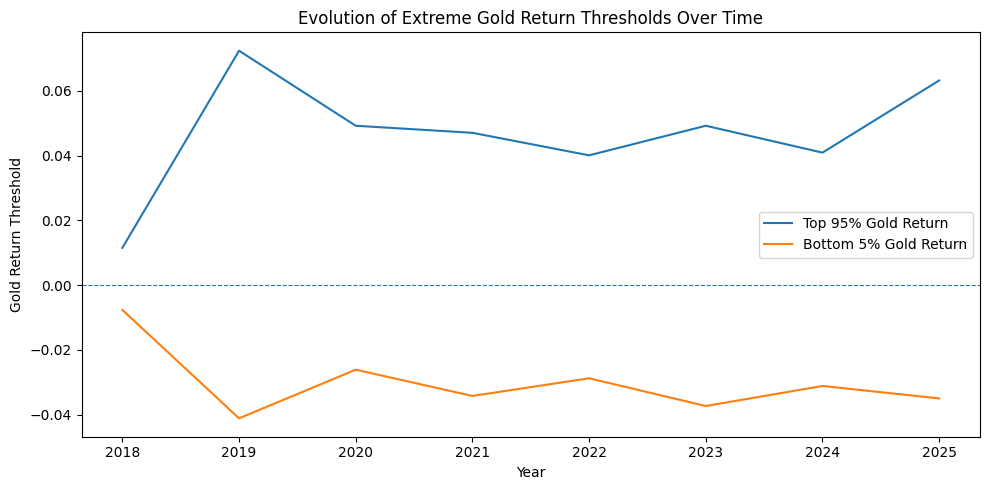

In [ ]:
# Gold Extreme Thresholds Over Time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gold_thresholds["Year"], gold_thresholds["Top_Gold_95"], label="Top 95% Gold Return")
plt.plot(gold_thresholds["Year"], gold_thresholds["Bottom_Gold_5"], label="Bottom 5% Gold Return")

plt.axhline(0, linestyle="--", linewidth=0.8)
plt.xlabel("Year")
plt.ylabel("Gold Return Threshold")
plt.title("Evolution of Extreme Gold Return Thresholds Over Time")
plt.legend()
plt.tight_layout()
plt.show()

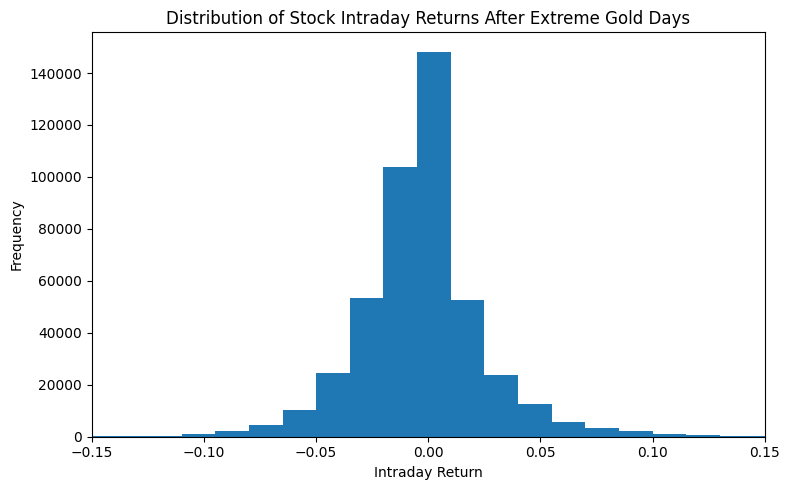

In [ ]:
# Distribution of Stock Reaction Returns
plt.figure(figsize=(8, 5))
plt.hist(stock_reactions["intraday_return"], bins=100)
plt.xlim(-0.15, 0.15)
plt.xlabel("Intraday Return")
plt.ylabel("Frequency")
plt.title("Distribution of Stock Intraday Returns After Extreme Gold Days")
plt.tight_layout()
plt.show()

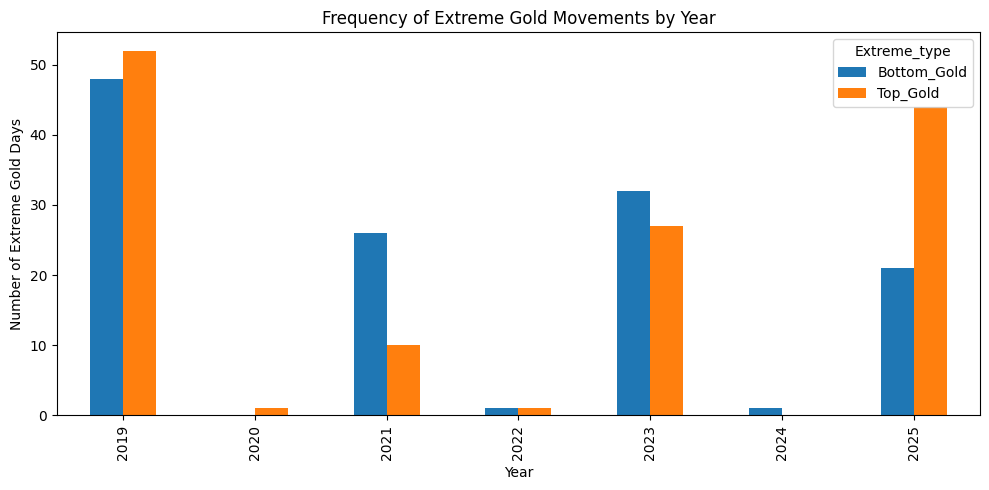

In [46]:
# Number of Extreme Gold Days Per Year
extreme_counts = (
    gold_extreme
    .groupby(["Year", "Extreme_type"])
    .size()
    .unstack(fill_value=0)
)

extreme_counts.plot(kind="bar", figsize=(10, 5))
plt.xlabel("Year")
plt.ylabel("Number of Extreme Gold Days")
plt.title("Frequency of Extreme Gold Movements by Year")
plt.tight_layout()
plt.show()

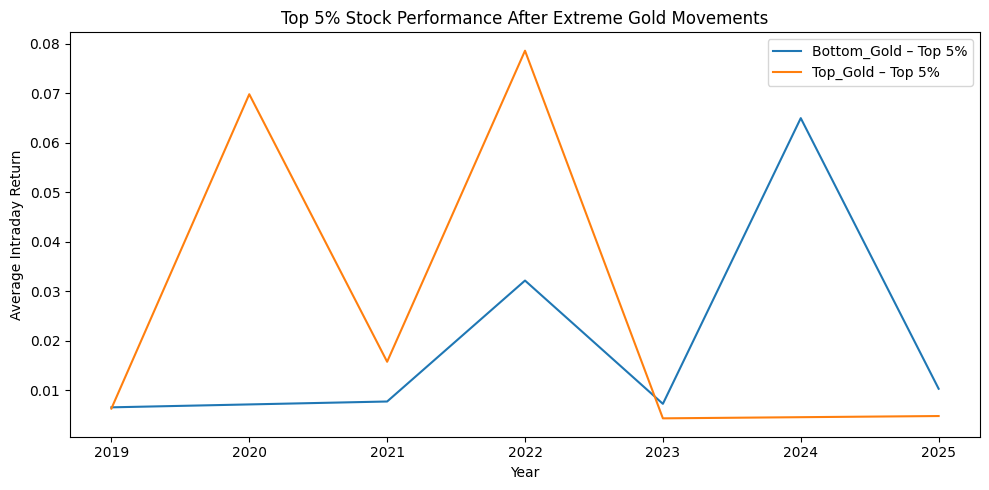

In [48]:
# Top Percentile Stock Performance
plt.figure(figsize=(10, 5))

for extreme in avg_returns["Extreme_type"].unique():
    subset = avg_returns[avg_returns["Extreme_type"] == extreme]
    plt.plot(
        subset.groupby("Year")["avg_intraday_return"].quantile(0.95),
        label=f"{extreme} – Top 5%"
    )

plt.xlabel("Year")
plt.ylabel("Average Intraday Return")
plt.title("Top 5% Stock Performance After Extreme Gold Movements")
plt.legend()
plt.tight_layout()
plt.show()